## Fourth Movement: Random Defender with CVE Data

In [53]:
print("""This Cell is necessary or else my IDE will start running cells simultaneously which
      then leads to issues with unfinished imports""")

This Cell is necessary or else my IDE will start running cells simultaneously which
      then leads to issues with unfinished imports


In [54]:
import os
import logging
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

## New Stuff

In [55]:
# Toggle to control execution mode
# True = standard calculation, False = includes 0 day exploit calculations (creates a separate file)
RUN_BASELINE_ONLY = False  

In [56]:
# Define experiment name as a variable for easy modification
experiment_name = "experiment_4"

In [57]:
# Set up main logger (original)
log_path = os.path.join(os.getcwd(), f'{experiment_name}.log')
if os.path.exists(log_path):
    os.remove(log_path)
logger = logging.getLogger()
handler = logging.FileHandler(log_path, mode='w')
handler.setFormatter(logging.Formatter('%(message)s'))
logger.addHandler(handler)
logger.setLevel(logging.INFO)
logger.info(f'[1] "{experiment_name}.log"')
logger.info(f'[1] "{datetime.now().strftime("%a %b %d %H:%M:%S %Y")}"')

# Set up subgraph logger if not RUN_BASELINE_ONLY:
if not RUN_BASELINE_ONLY:
    subgraph_log_path = os.path.join(os.getcwd(), f'sub_{experiment_name}.log')
    if os.path.exists(subgraph_log_path):
        os.remove(subgraph_log_path)
    subgraph_handler = logging.FileHandler(subgraph_log_path, mode='w')
    subgraph_handler.setFormatter(logging.Formatter('%(message)s'))
    # Don't add to logger yet

# Function to switch between loggers
def switch_logger(use_subgraph_logger=False):
    # Remove all handlers
    for hdlr in logger.handlers[:]:
        logger.removeHandler(hdlr)
        
    # Add appropriate handler
    if use_subgraph_logger:
        logger.addHandler(subgraph_handler)
        logger.info(f'[1] "sub_{experiment_name}.log"')
        logger.info(f'[1] "{datetime.now().strftime("%a %b %d %H:%M:%S %Y")}"')
    else:
        logger.addHandler(handler)

In [58]:
# Global configuration
# This is the default weight value we will insert any time we we 
# need to insert a weight value for a trivial edge in the graph
DEFAULT_WEIGHT_VALUE = 0  

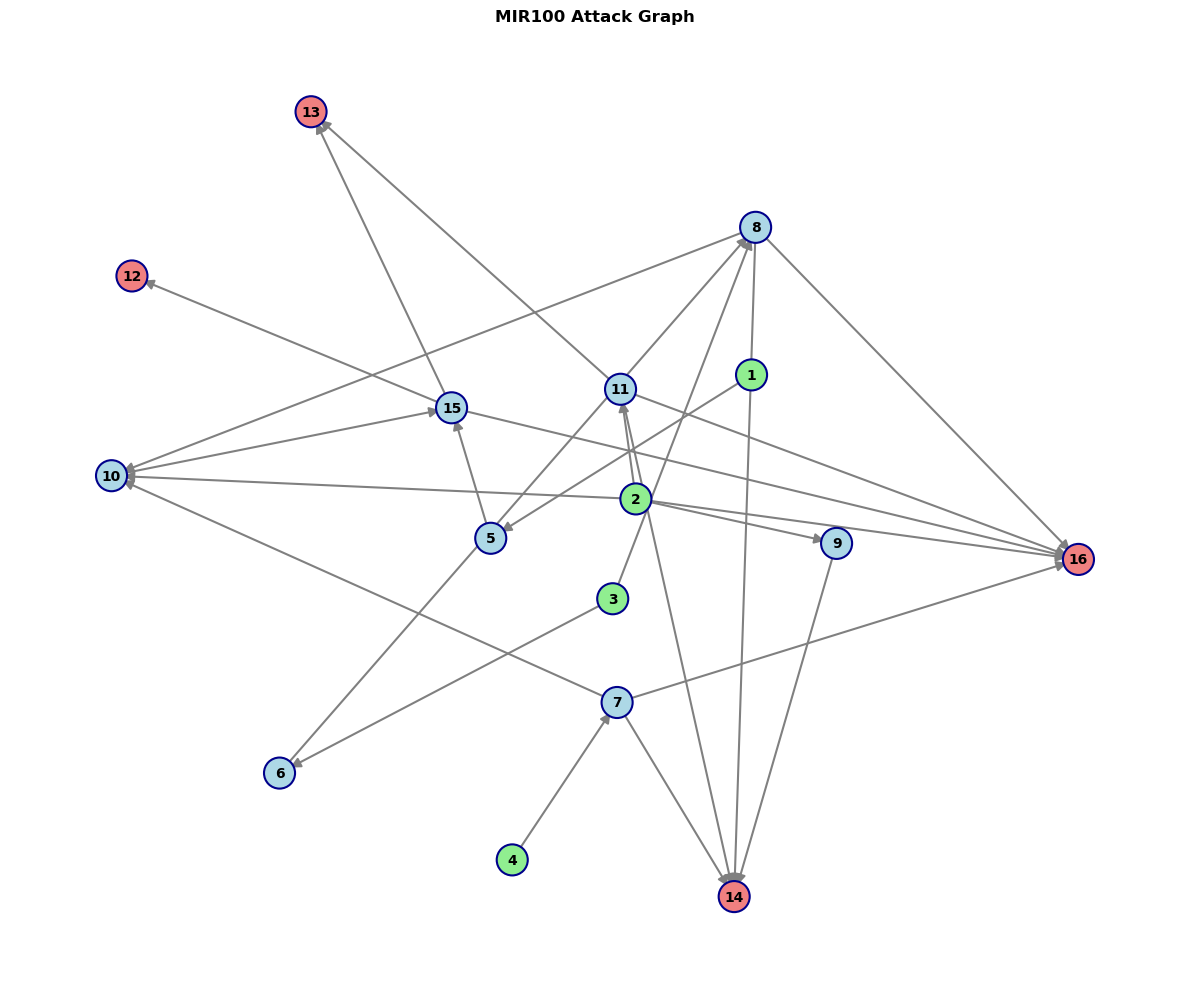

In [59]:
%run attack_graph_MIR100.ipynb

### Create Subgraphs

++++++++++++++++++++++++++++++++++++++++
Start dropping & cleanup for the next subgraph here
Identified 4 target nodes: [12, 13, 14, 16]
Dropping 2 nodes: [3, 2]
Original graph had 16 nodes, subgraph has 14 nodes
Original legitimate targets: [12, 13, 14, 16]
Remaining legitimate targets in subgraph: [12, 13, 14, 16]
Removing 0 unreachable nodes: set()
++++++++++++++++++++++++++++++++++++++++
Start dropping & cleanup for the next subgraph here
Identified 4 target nodes: [12, 13, 14, 16]
Dropping 2 nodes: [15, 5]
Original graph had 16 nodes, subgraph has 14 nodes
Original legitimate targets: [12, 13, 14, 16]
Remaining legitimate targets in subgraph: [12, 13, 14, 16]
Removing 2 unreachable nodes: {1, 10}
++++++++++++++++++++++++++++++++++++++++
Start dropping & cleanup for the next subgraph here
Identified 4 target nodes: [12, 13, 14, 16]
Dropping 2 nodes: [3, 9]
Original graph had 16 nodes, subgraph has 14 nodes
Original legitimate targets: [12, 13, 14, 16]
Remaining legitimate targets i

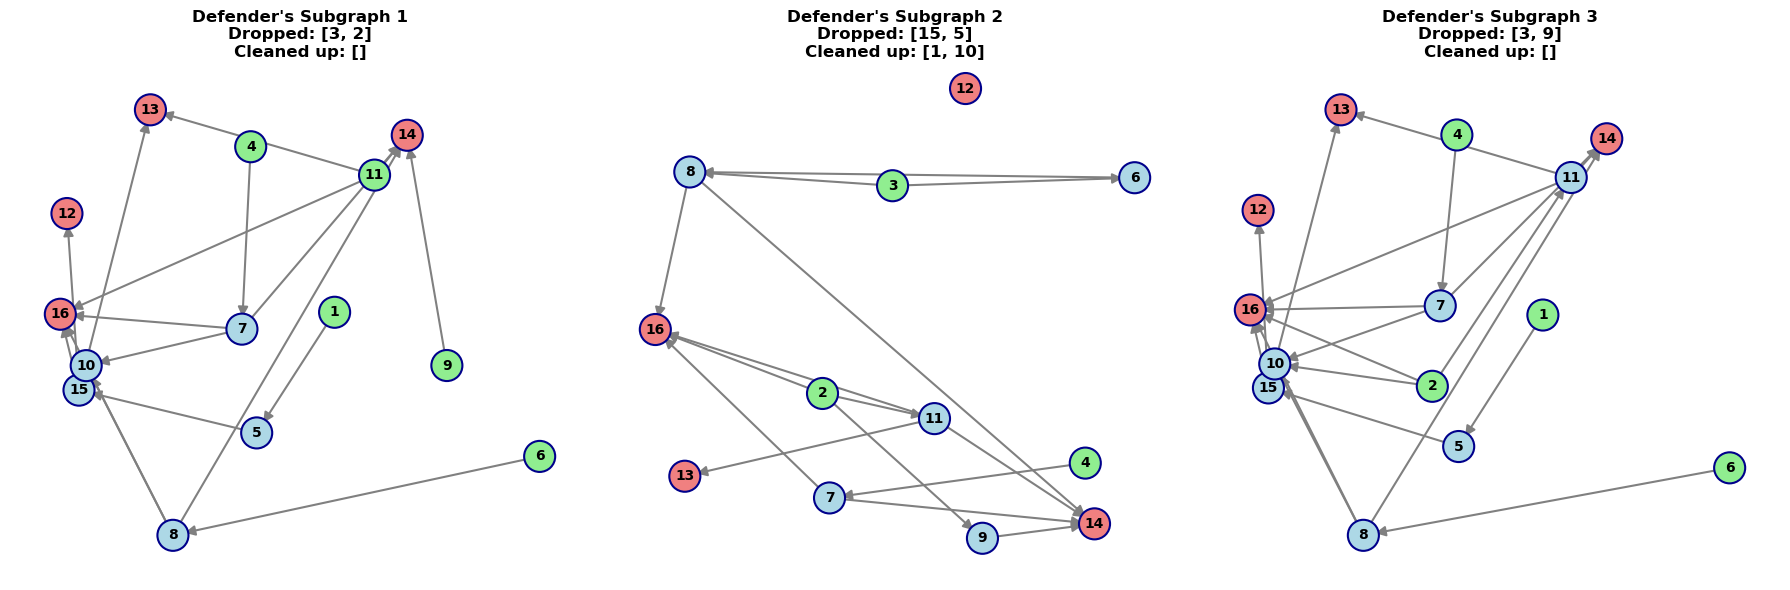

create subsgraph for defender concluded


In [60]:
%run create_subgraphs.ipynb

## Old Stuff

### Combined Random-Interval and Exploit-Dependent Distribution Explanations
#### Base Formula
This distribution models the probability of completing n exploits within a random time window, where both the defender's check interval and exploit difficulties vary:
\begin{equation}
f_N(n) = 
\begin{cases}
\left(\frac{\lambda_\pi}{\lambda_\pi + \lambda_D}\right)^n & \text{if } n \geq 1 \\
1 - Pr(E_1 \leq W) & \text{if } n = 0
\end{cases}
\end{equation}
Where $\lambda_\pi = 1/\bar{q}$ is the attack rate derived from exploit difficulties, and $\lambda_D$ is the defender's check rate.

#### Definition of Parameters in our Specific Case
In the code:
- Exploit success probabilities are derived from edge weights
- A geometric mean of these probabilities ($\bar{q}$) is used to calculate attack_rate
- The probability parameter is calculated as $p = \frac{\text{attack\_rate}}{\text{attack\_rate} + \text{defense\_rate}}$

This corresponds to formula (13) in the paper, which simplifies to another geometric distribution with modified parameters.

#### Basic Explanation
This distribution combines the unpredictable defender checking pattern with varying exploit difficulties:

- Defender checks at random times (exponentially distributed intervals)
- Each exploit has different difficulty (derived from CVE data)
- attack_rate is calculated as inverse of geometric mean of exploit probabilities
- defense_rate directly impacts how far attacker can progress
- Higher defense_rate → attacker progress more limited
- Lower defense_rate → attacker can attempt more difficult exploits

Key insight: This model captures the most realistic scenario where defenders have random checking patterns and attackers face varying technical challenges.

This fits our intuition: In real-world environments, security teams respond at unpredictable intervals while attackers encounter exploits of varying difficulty, creating a complex interplay that this distribution effectively models.

### Run the Code

In [61]:
attack_rate_list = [None]   
# defense_rate_list = [1,2,3]  
defense_rate_list = [1]  

In [62]:
def random_steps(route, attack_rate=None, defense_rate=None, graph=None):
    """
    Calculates probabilities for attacker movement along route.
    Returns probability distribution over possible ending nodes.
    """
    # Calculate hardness values for each edge 
    hardness = []
    for i in range(len(route) - 1):
        start_node = route[i]
        end_node = route[i + 1]
        
        # Initialize variables for max weight loop
        weights = []
        # Collect all weights for max
        for edge in graph[start_node][end_node].values():
            weights.append(edge.get('weight', DEFAULT_WEIGHT_VALUE))
        # Get maximum weight
        max_weight = max(weights) if weights else DEFAULT_WEIGHT_VALUE
        
        # Initialize variables for min weight loop
        min_weights = []
        # Collect all weights for min
        for edge in graph[start_node][end_node].values():
            min_weights.append(edge.get('weight', DEFAULT_WEIGHT_VALUE))
        # Get minimum weight
        min_weight = min(min_weights) if min_weights else DEFAULT_WEIGHT_VALUE
            
        # Convert weights to probabilities
        # We could take max_weight or min_weight here
        # hardness.append(np.exp(-max_weight))

        # Important: We use min_weight here because of the following reason:
        # Since the formula to calculate hardness in R is hardness = exp(-weight)
        # taking the minimum weight will give us the maximum hardness
        # which translates to the path being EASIEST to traverse.
        # Yes hardness of 1 means path is trivial, hardness 0 means path is impossible
        hardness.append(np.exp(-min_weight))

    
    # Convert to arrays
    hardness = np.array(hardness)

    # print(f'Hardness: {hardness}')
    
    # Calculate attack rate using geometric mean if not provided
    if attack_rate is None:
        # Geometric mean function (mirrors the R geomean function)
        def geom_mean(x):
            # Filter out zeros to avoid log(0)
            positive_values = x[x > 0]
            if len(positive_values) == 0:
                return 1  # Default if all values are zero or array is empty
            return np.exp(np.mean(np.log(positive_values)))
        
        attack_rate = 1 / geom_mean(hardness)
    
    # Calculate probability distribution using geometric distribution
    # Equivalent to R's dgeom function
    prob = attack_rate / (attack_rate + defense_rate)
    
    # Create range of values from 0 to length(route)-1
    x_values = np.arange(len(route))
    
    # Calculate probability mass function (pmf) for geometric distribution
    # pdf_d = geom.pmf(x_values, prob)
    pdf_d = prob * (1-prob)**x_values
    
    # Normalize to ensure probabilities sum to 1
    pdf_d = pdf_d / np.sum(pdf_d)
    
    # print(f"This is the final pdf that is returned in the end: {pdf_d}")
    return pdf_d

# Example usage:
# route = [1, 2, 3, 4]
# defense_rate = 2
# pdf = random_steps(route, attack_graph=G, defense_rate=defense_rate)

In [63]:
# %run ctr-core_simple.ipynb
%run exp_ctr-core.ipynb
main()

We start with the baseline graph calculation!

This is the Attacker Graph:
Nodes: [1, 5, 15, 12, 11, 13, 3, 6, 8, 4, 7, 2, 9, 10, 14, 16]
Total list of Edges with their weights:
1 -> 5 : 2.1958405355640576
5 -> 15 : 2.1958405355640576
15 -> 12 : 0.7489220813074156
15 -> 13 : 0.7489220813074156
15 -> 16 : 0.7489220813074156
11 -> 13 : 1.064439873679208
11 -> 14 : 0.7489220813074156
11 -> 16 : 0.0
3 -> 6 : 1.064439873679208
3 -> 8 : 0.7489220813074156
6 -> 8 : 0.0
8 -> 10 : 0.0
8 -> 14 : 0.0
8 -> 16 : 0.7489220813074156
4 -> 7 : 0.7489220813074156
7 -> 10 : 0.7489220813074156
7 -> 14 : 0.7489220813074156
7 -> 16 : 0.7489220813074156
2 -> 9 : 0.7489220813074156
2 -> 10 : 1.064439873679208
2 -> 11 : 0.7489220813074156
2 -> 16 : 1.064439873679208
9 -> 14 : 1.064439873679208
10 -> 15 : 0.0

After merging targets of attack graph:
Nodes: [1, 5, 15, 11, 3, 6, 8, 4, 7, 2, 9, 10, 0, 'c(12,13,14,16)']
Total list of Edges with their weights:
1 -> 5 (key=0) : 2.1958405355640576
5 -> 15 (key=0) : 2.1

In [64]:
with open(experiment_name+'.log', 'r') as f:
    print(f.read())

[1] "experiment_4.log"
[1] "Sun Mar 09 13:15:13 2025"



BASELINE RUN: BOTH ATTACKER AND DEFENDER HAVE FULL GRAPH KNOWLEDGE



++++++++++++++++++++++++++++++++

The virtual target nodeID is c(12,13,14,16)

attack rate =  None , defense rate =  1 

	equilibrium for multiobjective security game (MOSG)

optimal defense strategy:
         prob.
1 0.000000e+00
10 0.000000e+00
11 3.117287e-01
15 2.283505e-01
2 0.000000e+00
3 0.000000e+00
4 0.000000e+00
5 0.000000e+00
6 0.000000e+00
7 4.236365e-02
8 4.175572e-01
9 0.000000e+00

worst case attack strategies per goal:
          1
1 0.0000000
2 0.2019000
3 0.0000000
4 0.0000000
5 0.0000000
6 0.2937196
7 0.2657957
8 0.0000000
9 0.0000000
10 0.0000000
11 0.2385847
[1] 0.025

Defender can keep attacker success below: 0.025
Attacker can guarantee success probability of: 0.025

